In [1]:
import numpy as np
import pandas as pd
import os
import textwrap
import re 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
from sklearn.metrics import make_scorer, roc_auc_score ,confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.dataset import ValidSplit


In [2]:
data_dir = 'data_readinglevel'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

N, n_cols = x_train_df.shape
print("Shape of x_train_df: (%d, %d)" % (N, n_cols))
print("Shape of y_train_df: %s" % str(y_train_df.shape))
print(x_train_df["word_count"])

Shape of x_train_df: (5557, 32)
Shape of y_train_df: (5557, 5)
0       119.0
1        61.0
2       133.0
3       118.0
4        80.0
        ...  
5552     89.0
5553     94.0
5554     91.0
5555     99.0
5556     96.0
Name: word_count, Length: 5557, dtype: float64


In [3]:
y_train_df['stage_encoded'] = y_train_df['Coarse Label'].map({'Key Stage 2-3': 0, 'Key Stage 4-5': 1})


In [4]:
y_train_clean = y_train_df['stage_encoded']
random_state=1543
zero=0
for i in y_train_clean:
    if i==0:zero+=1
print(zero)

2509


In [8]:
tr_text_list = x_train_df['text'].values.tolist()

def custom_preprocessor(text):
        
   
        text = re.sub(r"_", " ", text)  # Replace underscores with spaces
        text = re.sub(r"\d+", "", text)  # Remove numbers
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
        return text.lower().strip()  # Convert to lowercase and trim space
    
#print(tr_text_list[:10])

def custom_tokenizer(text):
    return re.findall(r"\w+|[^\w\s]", text)  # Matches words OR punctuation separately

X_train_val, X_test, y_train_val, y_test = train_test_split(tr_text_list, y_train_clean, test_size=0.1, random_state=1543, stratify=y_train_clean)
print(len(X_test))
print(len(X_train_val))

556
5001


In [ ]:
from scipy.stats import loguniform
class MLP(nn.Module):
    def __init__(self, input_size, hidden_units, activation='relu'):
        super().__init__()
        self.layers = nn.ModuleList()
        prev_units = input_size
        activation_class = {
            'relu': nn.ReLU,
            'tanh': nn.Tanh,
            'logistic': nn.Sigmoid
        }[activation]
        for units in hidden_units:
            self.layers.append(nn.Linear(prev_units, units))
            self.layers.append(activation_class())
            prev_units = units
        self.output_layer = nn.Linear(prev_units, 1)
    
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        logits = self.output_layer(X)
        return logits.squeeze(-1) 
# vectorizer = TfidfVectorizer(preprocessor=custom_preprocessor)
my_bow_classifier_pipeline = sklearn.pipeline.Pipeline([
   # ('bow', CountVectorizer(min_df=1,max_df=1, ngram_range=(1,1),stop_words=None,token_pattern = r'(?u)\b[\w-]+\b',lowercase = False))
     ('tfidf', TfidfVectorizer(min_df=1, max_df=1, ngram_range=(1,1), 
                              stop_words=None, token_pattern=r'(?u)\b[\w-]+\b', 
                              lowercase=False,norm='l2',tokenizer=None,preprocessor=None,analyzer='word')),
    ('class', NeuralNetClassifier(
        module=MLP,
        module__input_size=X_train_val.shape[1],
        module__hidden_units=(64,),
        module__activation='relu',
        optimizer=optim.Adam,
        criterion=nn.BCEWithLogitsLoss,
        max_epochs=200,
        batch_size=32,
        callbacks=[
            EarlyStopping(patience=5)
        ],
        train_split=ValidSplit(0.1, stratified=True),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=1
    )),
])
my_parameter_grid_by_name = dict()
my_parameter_grid_by_name['tfidf__min_df'] = [1,2,5,10,30,50] 
my_parameter_grid_by_name['tfidf__max_df'] = [0.7,0.75, 0.8,0.85]   
#my_parameter_grid_by_name['tfidf__max_df'] = loguniform(0.7, 0.85) 
my_parameter_grid_by_name['tfidf__ngram_range'] = [ (1,1),(1,2)]
my_parameter_grid_by_name['tfidf__stop_words'] = [None,'english']
my_parameter_grid_by_name['tfidf__token_pattern'] = [
    r'(?u)\b\w{2,}\b',    # Words with at least two characters
    r'(?u)\b[a-zA-Z]+\b', # Only alphabetic words, ignoring numbers
]
#my_parameter_grid_by_name['tfidf__analyzer'] = ['word']
my_parameter_grid_by_name['tfidf__lowercase'] = [True,False]
# my_parameter_grid_by_name['class__C'] = np.logspace(-4, 4, 100)
# #my_parameter_grid_by_name['class__C'] = loguniform(1e-1, 1e2) 
# my_parameter_grid_by_name['class__penalty'] = ['l2',None] 
#my_parameter_grid_by_name['class__solver'] = ['lbfgs']
#my_parameter_grid_by_name['tfidf__preprocessor'] = [None]
my_parameter_grid_by_name['tfidf__tokenizer']= [None,custom_tokenizer]
#my_parameter_grid_by_name['tfidf__norm'] = ['l2']
#my_parameter_grid_by_name['tfidf__smooth_idf'] = [False]


#my_scoring_metric_name = 'accuracy'
my_scoring_metric_name = 'roc_auc'

In [91]:
# prng = np.random.RandomState(0)

# valid_ids = prng.choice(np.arange(N), size=round(N/5))

n_iter = [500,1000]
# valid_indicators_N = np.zeros(N)
# valid_indicators_N[valid_ids] = -1
# my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_N)
y_train_clean = list(y_train_clean)
my_best_models = []
best_test_scores = []
for iter in n_iter:
    random_searcher = RandomizedSearchCV(
    my_bow_classifier_pipeline,
    my_parameter_grid_by_name,
    scoring=my_scoring_metric_name ,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
    refit=True,
    n_iter=iter,  
    random_state=random_state, 
    n_jobs=-1,
    return_train_score=True 
    )
    random_searcher.fit(X_train_val, y_train_val)
    # Get the best-trained model (automatically refit on full training data)
    best_model = random_searcher.best_estimator_
    my_best_models.append(best_model)

    # Best hyperparameters
    best_params = random_searcher.best_params_
    print("Best Hyperparameters:", best_params)

    # Best cross-validation score (average accuracy across folds)
    best_score = random_searcher.best_score_
    print(f"Best CV AUROC: for {iter} iterations is {best_score:.4f}")

    #use best model to get predictions on test data
    y_test_probs = best_model.predict_proba(X_test)[:, 1]  

    # Compute ROC AUC score
    roc_auc = roc_auc_score(y_test, y_test_probs)
    best_test_scores.append(roc_auc)
    predicted_labels = np.where(y_test_probs >= 0.5, 1, 0)
    cm = confusion_matrix(y_test,predicted_labels )
    cm_df = pd.DataFrame(cm, 
                     index=['Actual 0', 'Actual 1'], 
                     columns=['Predicted 0', 'Predicted 1'])

    print(cm_df)
    print(f"Test Set ROC AUC Score for {iter}:", roc_auc)



c:\Users\ningn\anaconda3\envs\cs135_25s_env\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best Hyperparameters: {'tfidf__tokenizer': <function custom_tokenizer at 0x000001E61BA3FF60>, 'tfidf__token_pattern': '(?u)\\b\\w{2,}\\b', 'tfidf__stop_words': 'english', 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_df': 0.7, 'tfidf__lowercase': False, 'class__penalty': 'l2', 'class__C': 65.79332246575683}
Best CV AUROC: for 500 iterations is 0.8448
          Predicted 0  Predicted 1
Actual 0          361          141
Actual 1          111          499
Test Set ROC AUC Score for 500: 0.8544902357781987


c:\Users\ningn\anaconda3\envs\cs135_25s_env\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best Hyperparameters: {'tfidf__tokenizer': <function custom_tokenizer at 0x000001E61BA3FF60>, 'tfidf__token_pattern': '(?u)\\b\\w{2,}\\b', 'tfidf__stop_words': 'english', 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_df': 0.7, 'tfidf__lowercase': False, 'class__penalty': 'l2', 'class__C': 65.79332246575683}
Best CV AUROC: for 1000 iterations is 0.8448
          Predicted 0  Predicted 1
Actual 0          361          141
Actual 1          111          499
Test Set ROC AUC Score for 1000: 0.8544902357781987


In [100]:
print(n_iter[np.argmax(best_test_scores)])
best_model_overall = my_best_models[np.argmax(best_test_scores)]
print(best_model_overall.get_params())
#print(y_test.shape)

overall_train_roc = roc_auc_score(y_train_clean,best_model_overall.predict_proba(tr_text_list)[:,1])

print(overall_train_roc)

500
{'memory': None, 'steps': [('tfidf', TfidfVectorizer(lowercase=False, max_df=0.7, min_df=2, ngram_range=(1, 2),
                stop_words='english', token_pattern='(?u)\\b\\w{2,}\\b',
                tokenizer=<function custom_tokenizer at 0x000001E61BA3FF60>)), ('class', LogisticRegression(C=65.79332246575683, max_iter=350, random_state=1543))], 'verbose': False, 'tfidf': TfidfVectorizer(lowercase=False, max_df=0.7, min_df=2, ngram_range=(1, 2),
                stop_words='english', token_pattern='(?u)\\b\\w{2,}\\b',
                tokenizer=<function custom_tokenizer at 0x000001E61BA3FF60>), 'class': LogisticRegression(C=65.79332246575683, max_iter=350, random_state=1543), 'tfidf__analyzer': 'word', 'tfidf__binary': False, 'tfidf__decode_error': 'strict', 'tfidf__dtype': <class 'numpy.float64'>, 'tfidf__encoding': 'utf-8', 'tfidf__input': 'content', 'tfidf__lowercase': False, 'tfidf__max_df': 0.7, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 't

In [101]:
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
tr_test_list = x_test_df['text'].values.tolist()
#print(tr_test_list[:5])
yproba_N2 = best_model_overall.predict_proba(tr_test_list)
print(yproba_N2[:5])
y_proba_N1 = yproba_N2[:,1]
print(y_proba_N1[:5])
print(y_proba_N1.shape)
np.savetxt("yproba1_test.txt", y_proba_N1, fmt="%.6f")

[[0.0422085  0.9577915 ]
 [0.00685335 0.99314665]
 [0.28470113 0.71529887]
 [0.00862169 0.99137831]
 [0.02494886 0.97505114]]
[0.9577915  0.99314665 0.71529887 0.99137831 0.97505114]
(1197,)


In [102]:
loaded_probs = np.loadtxt('yproba1_test.txt')
print(loaded_probs.shape)

(1197,)


In [103]:
import pandas as pd


results_df = pd.DataFrame(random_searcher.cv_results_)

param_columns = [col for col in results_df.columns if col.startswith("param_")]
for col in param_columns:

    results_df[col] = results_df[col].apply(
        lambda x: 'None' if x is None else str(x) 
    )

results_df = results_df[param_columns + ["mean_test_score"]]

In [104]:
results_df = pd.DataFrame(random_searcher.cv_results_)
results_df = results_df.replace({None: "None"})
results_df['param_tfidf__tokenizer'] = (
    results_df['param_tfidf__tokenizer']
    .apply(lambda x: 'None' if x is None else str(x))
)
tokenizer_mapping = {
    '<function custom_tokenizer at 0x000001E6233CC0E0>': 'custom_tokenizer',
    'None': 'None'
}
results_df['param_tfidf__tokenizer'] = (
    results_df['param_tfidf__tokenizer']
    .map(tokenizer_mapping)
    .fillna(results_df['param_tfidf__tokenizer']) 
)
results_df["param_tfidf__ngram_range"] = results_df["param_tfidf__ngram_range"].astype(str)
for i in range(len(results_df['param_class__C'])):
    results_df['param_class__C'][i] = np.round(float(results_df['param_class__C'][i]),3)
    results_df['param_tfidf__max_df'][i] = float(results_df['param_tfidf__max_df'][i])
    results_df['param_tfidf__min_df'][i] = float(results_df['param_tfidf__min_df'][i])

C:\Users\ningn\AppData\Local\Temp\ipykernel_45296\2901008489.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['param_class__C'][i] = np.round(float(results_df['param_class__C'][i]),3)
C:\Users\ningn\AppData\Local\Temp\ipykernel_45296\2901008489.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['param_tfidf__max_df'][i] = float(results_df['param_tfidf__max_df'][i])
C:\Users\ningn\AppData\Local\Temp\ipykernel_45296\2901008489.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [97]:
results_df.loc[results_df["param_tfidf__stop_words"] != "None"]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__tokenizer,param_tfidf__token_pattern,param_tfidf__stop_words,param_tfidf__ngram_range,param_tfidf__min_df,param_tfidf__max_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,0.897164,0.172958,0.145359,0.026189,<function custom_tokenizer at 0x000001E61BA3FF60>,"(?u)\b\w{2,}\b",english,"(1, 2)",2,0.70,...,0.833760,0.008629,37,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.713460,0.137755,0.112331,0.008985,<function custom_tokenizer at 0x000001E61BA3FF60>,"(?u)\b\w{2,}\b",english,"(1, 2)",10,0.70,...,0.766870,0.013535,476,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.685029,0.092157,0.086550,0.010956,None,(?u)\b[a-zA-Z]+\b,english,"(1, 2)",2,0.80,...,0.766486,0.014802,480,0.853197,0.852189,0.854078,0.843801,0.850399,0.850733,0.003676
8,0.286071,0.074860,0.056703,0.014744,None,"(?u)\b\w{2,}\b",english,"(1, 1)",50,0.75,...,0.692132,0.011544,974,0.790991,0.784361,0.786514,0.789351,0.786748,0.787593,0.002322
9,0.498191,0.019659,0.077014,0.006706,None,(?u)\b[a-zA-Z]+\b,english,"(1, 2)",30,0.75,...,0.729789,0.013527,714,0.768534,0.763867,0.766517,0.761649,0.764114,0.764936,0.002369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0.204579,0.006838,0.042057,0.001574,None,(?u)\b[a-zA-Z]+\b,english,"(1, 1)",30,0.75,...,0.727092,0.009364,742,0.772806,0.767593,0.770626,0.766082,0.767325,0.768886,0.002464
994,0.582591,0.044448,0.096925,0.005731,<function custom_tokenizer at 0x000001E61BA3FF60>,(?u)\b[a-zA-Z]+\b,english,"(1, 2)",10,0.85,...,0.795140,0.008383,364,0.957320,0.956994,0.957745,0.955995,0.956953,0.957002,0.000578
995,0.262393,0.048028,0.044781,0.003792,None,(?u)\b[a-zA-Z]+\b,english,"(1, 1)",10,0.70,...,0.756027,0.009633,528,0.819398,0.815207,0.819143,0.816321,0.814180,0.816850,0.002091
996,0.264302,0.013250,0.052074,0.005514,None,"(?u)\b\w{2,}\b",english,"(1, 1)",2,0.80,...,0.820866,0.011266,190,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


tfidf__tokenizer
                                     tfidf__tokenizer     Score        Type
0   <function custom_tokenizer at 0x000001E61BA3FF60>  0.911777    Training
1                                                None  0.927486    Training
2   <function custom_tokenizer at 0x000001E61BA3FF60>  0.758838  Validation
3                                                None  0.755251  Validation
4   <function custom_tokenizer at 0x000001E61BA3FF60>  0.909493    Training
5                                                None  0.924956    Training
6   <function custom_tokenizer at 0x000001E61BA3FF60>  0.781628  Validation
7                                                None  0.778009  Validation
8   <function custom_tokenizer at 0x000001E61BA3FF60>  0.910626    Training
9                                                None  0.926394    Training
10  <function custom_tokenizer at 0x000001E61BA3FF60>  0.764149  Validation
11                                               None  0.760203  Valida

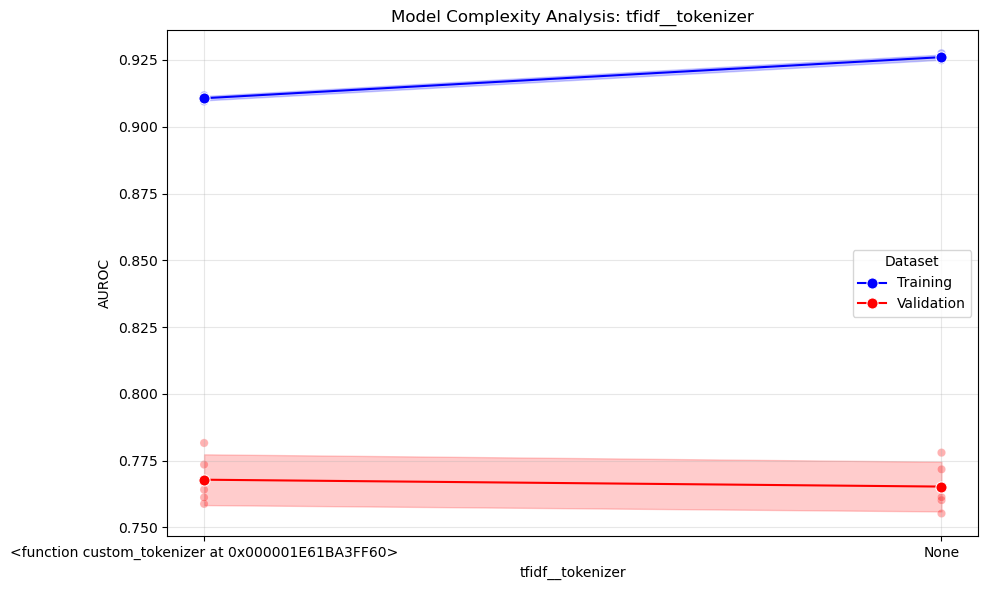

tfidf__token_pattern
   tfidf__token_pattern     Score        Type
0        (?u)\b\w{2,}\b  0.919341    Training
1     (?u)\b[a-zA-Z]+\b  0.919516    Training
2        (?u)\b\w{2,}\b  0.757639  Validation
3     (?u)\b[a-zA-Z]+\b  0.756525  Validation
4        (?u)\b\w{2,}\b  0.916878    Training
5     (?u)\b[a-zA-Z]+\b  0.917174    Training
6        (?u)\b\w{2,}\b  0.780713  Validation
7     (?u)\b[a-zA-Z]+\b  0.778991  Validation
8        (?u)\b\w{2,}\b  0.918314    Training
9     (?u)\b[a-zA-Z]+\b  0.918296    Training
10       (?u)\b\w{2,}\b  0.760799  Validation
11    (?u)\b[a-zA-Z]+\b  0.763702  Validation
12       (?u)\b\w{2,}\b  0.918037    Training
13    (?u)\b[a-zA-Z]+\b  0.917885    Training
14       (?u)\b\w{2,}\b  0.761424  Validation
15    (?u)\b[a-zA-Z]+\b  0.761111  Validation
16       (?u)\b\w{2,}\b  0.918036    Training
17    (?u)\b[a-zA-Z]+\b  0.918229    Training
18       (?u)\b\w{2,}\b  0.772515  Validation
19    (?u)\b[a-zA-Z]+\b  0.772839  Validation


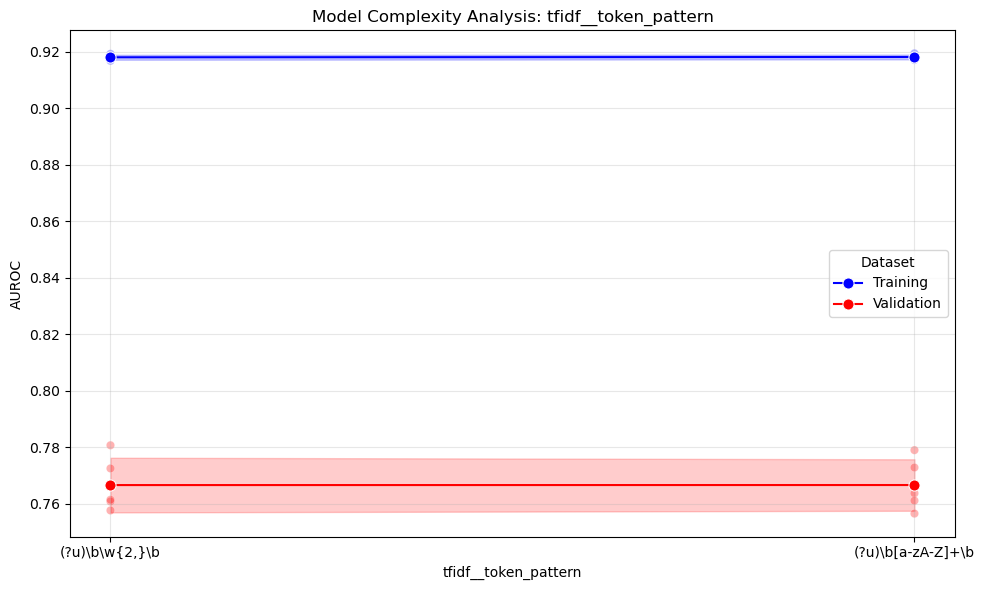

tfidf__stop_words
   tfidf__stop_words     Score        Type
0               None  0.930082    Training
1            english  0.908858    Training
2               None  0.759532  Validation
3            english  0.754670  Validation
4               None  0.928196    Training
5            english  0.905940    Training
6               None  0.780529  Validation
7            english  0.779208  Validation
8               None  0.929333    Training
9            english  0.907365    Training
10              None  0.761845  Validation
11           english  0.762607  Validation
12              None  0.929243    Training
13           english  0.906771    Training
14              None  0.760805  Validation
15           english  0.761731  Validation
16              None  0.929041    Training
17           english  0.907307    Training
18              None  0.772048  Validation
19           english  0.773295  Validation


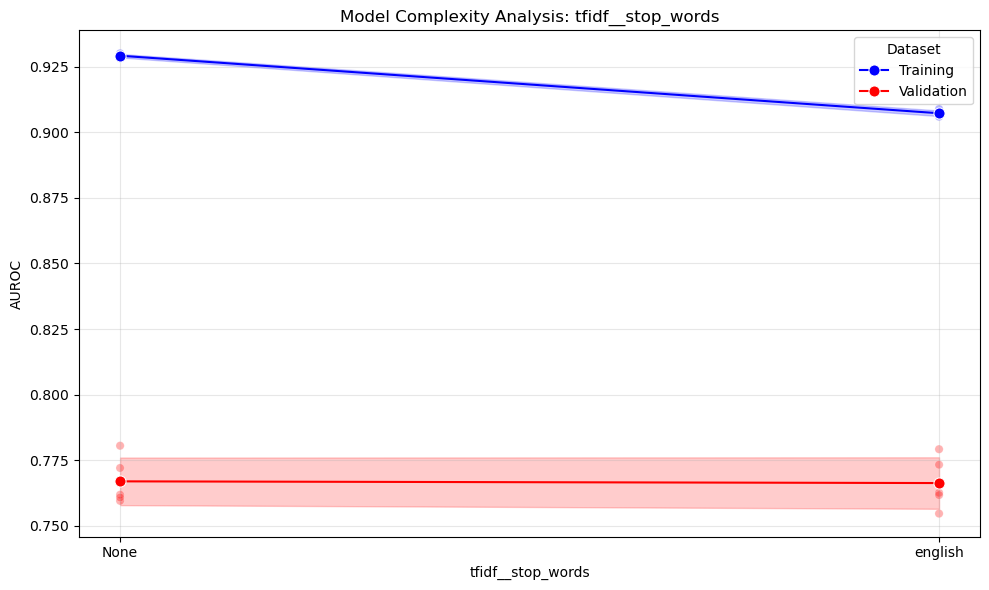

tfidf__ngram_range
   tfidf__ngram_range     Score        Type
0              (1, 2)  0.927299    Training
1              (1, 1)  0.911136    Training
2              (1, 2)  0.760775  Validation
3              (1, 1)  0.753211  Validation
4              (1, 2)  0.925372    Training
5              (1, 1)  0.908229    Training
6              (1, 2)  0.779770  Validation
7              (1, 1)  0.779967  Validation
8              (1, 2)  0.926468    Training
9              (1, 1)  0.909706    Training
10             (1, 2)  0.765678  Validation
11             (1, 1)  0.758592  Validation
12             (1, 2)  0.926274    Training
13             (1, 1)  0.909206    Training
14             (1, 2)  0.762413  Validation
15             (1, 1)  0.760066  Validation
16             (1, 2)  0.926170    Training
17             (1, 1)  0.909662    Training
18             (1, 2)  0.776729  Validation
19             (1, 1)  0.768403  Validation


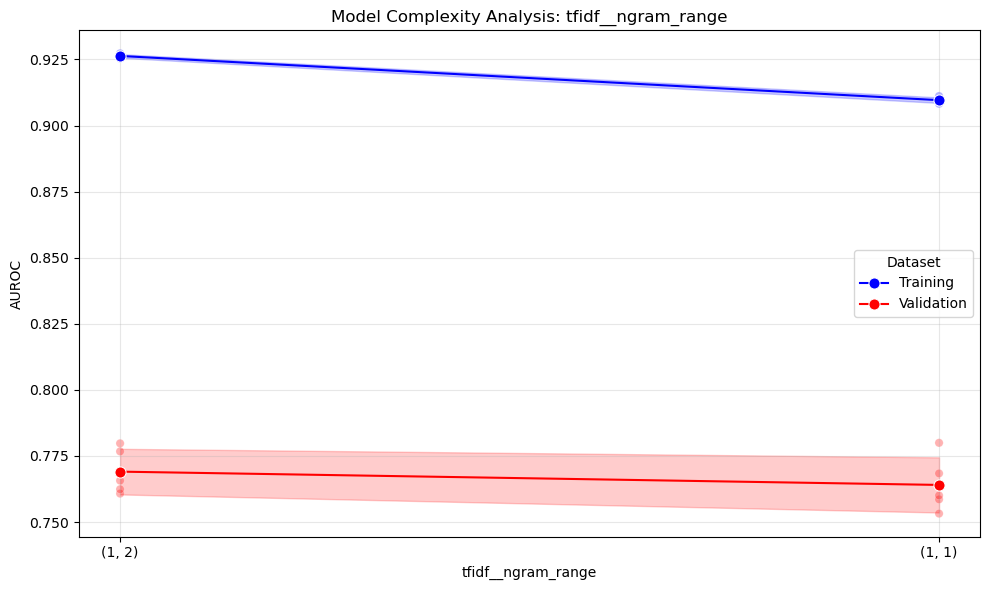

tfidf__min_df
    tfidf__min_df     Score        Type
0              10  0.948965    Training
1               2  0.961174    Training
2              50  0.822059    Training
3               5  0.951027    Training
4              30  0.870269    Training
5               1  0.963197    Training
6              10  0.745379  Validation
7               2  0.800512  Validation
8              50  0.703701  Validation
9               5  0.781599  Validation
10             30  0.711960  Validation
11              1  0.799436  Validation
12             10  0.948302    Training
13              2  0.960839    Training
14             50  0.815009    Training
15              5  0.950426    Training
16             30  0.864512    Training
17              1  0.963112    Training
18             10  0.772135  Validation
19              2  0.822947  Validation
20             50  0.727685  Validation
21              5  0.803545  Validation
22             30  0.736024  Validation
23              1  0.81659

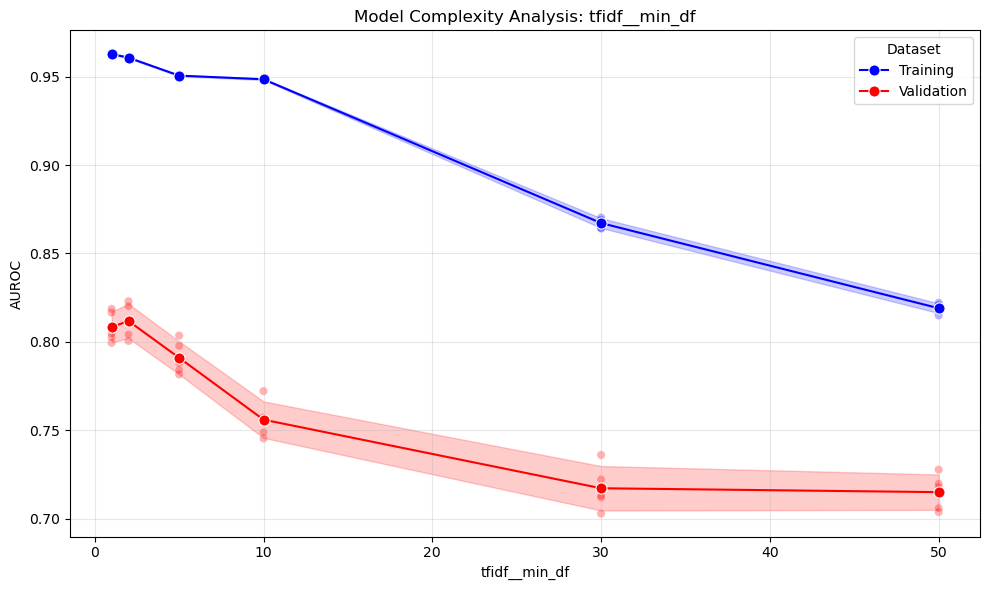

tfidf__max_df
    tfidf__max_df     Score        Type
0            0.75  0.919617    Training
1            0.70  0.919397    Training
2            0.85  0.919185    Training
3            0.80  0.919513    Training
4            0.75  0.756427  Validation
5            0.70  0.756050  Validation
6            0.85  0.756999  Validation
7            0.80  0.758707  Validation
8            0.75  0.917035    Training
9            0.70  0.916872    Training
10           0.85  0.917102    Training
11           0.80  0.917085    Training
12           0.75  0.779446  Validation
13           0.70  0.778417  Validation
14           0.85  0.779533  Validation
15           0.80  0.781869  Validation
16           0.75  0.918404    Training
17           0.70  0.918160    Training
18           0.85  0.918241    Training
19           0.80  0.918413    Training
20           0.75  0.761777  Validation
21           0.70  0.760758  Validation
22           0.85  0.761514  Validation
23           0.80  0.76461

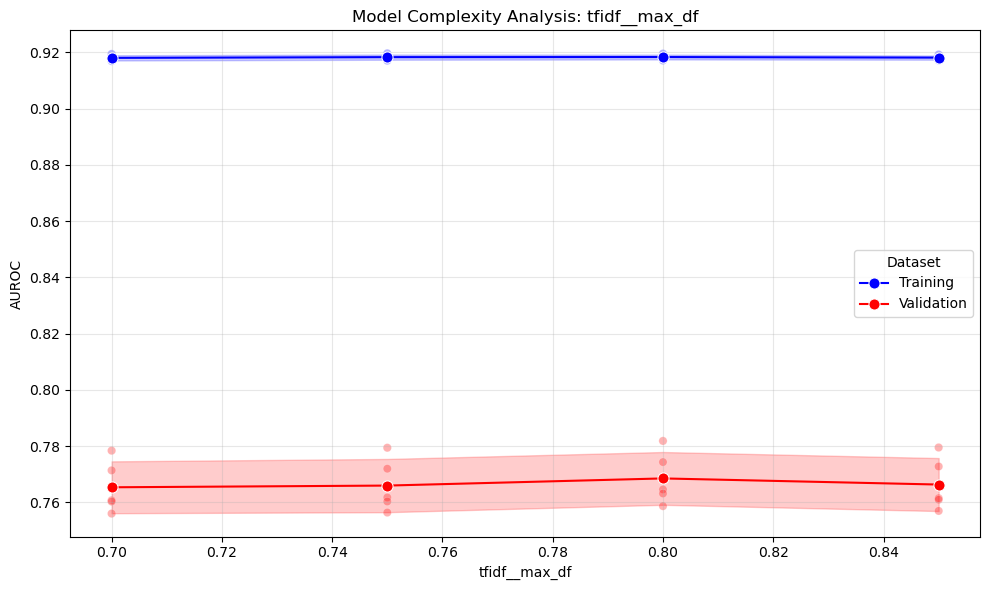

tfidf__lowercase
    tfidf__lowercase     Score        Type
0              False  0.923087    Training
1               True  0.915840    Training
2              False  0.760195  Validation
3               True  0.754049  Validation
4              False  0.920420    Training
5               True  0.913695    Training
6              False  0.784187  Validation
7               True  0.775630  Validation
8              False  0.922097    Training
9               True  0.914588    Training
10             False  0.761735  Validation
11              True  0.762710  Validation
12             False  0.921544    Training
13              True  0.914451    Training
14             False  0.763988  Validation
15              True  0.758606  Validation
16             False  0.921909    Training
17              True  0.914427    Training
18             False  0.772757  Validation
19              True  0.772594  Validation


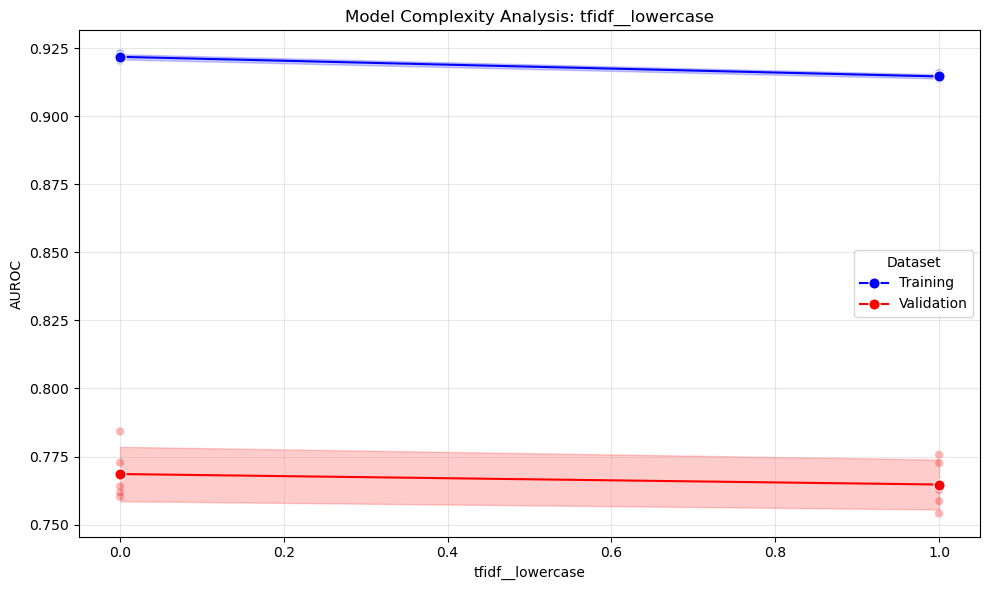

class__penalty
   class__penalty     Score        Type
0            None  0.957322    Training
1              l2  0.883309    Training
2            None  0.756137  Validation
3              l2  0.758001  Validation
4            None  0.954734    Training
5              l2  0.881081    Training
6            None  0.782902  Validation
7              l2  0.776972  Validation
8            None  0.956057    Training
9              l2  0.882323    Training
10           None  0.763271  Validation
11             l2  0.761232  Validation
12           None  0.955818    Training
13             l2  0.881880    Training
14           None  0.769081  Validation
15             l2  0.753825  Validation
16           None  0.956733    Training
17             l2  0.881338    Training
18           None  0.770810  Validation
19             l2  0.774451  Validation


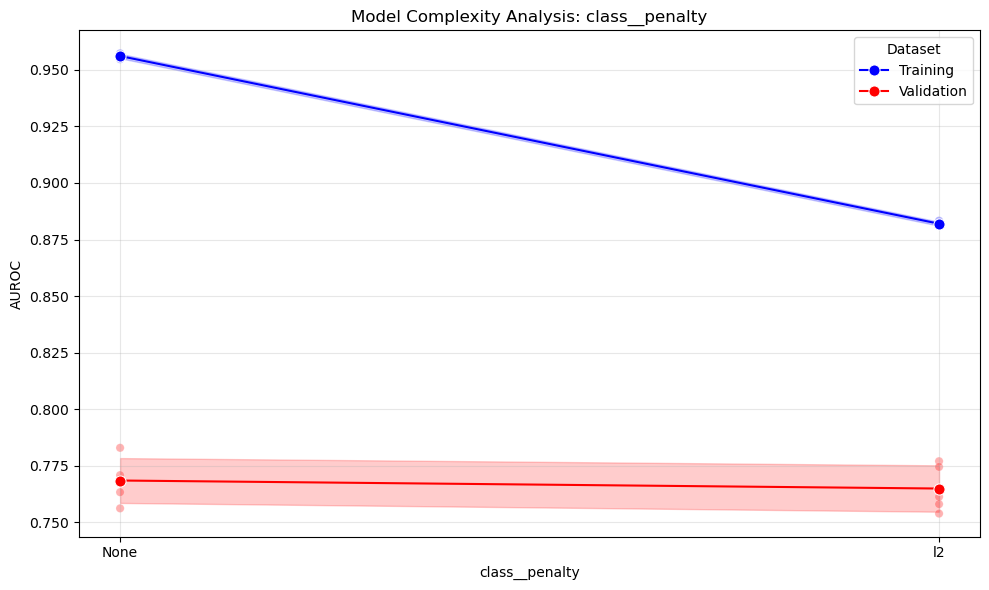

class__C
     class__C     Score        Type
0       0.039  0.920577    Training
1     422.924  0.949472    Training
2      21.544  0.999971    Training
3       0.001  0.857172    Training
4       1.322  0.971459    Training
..        ...       ...         ...
835     4.863  0.821278  Validation
836  8302.176  0.775870  Validation
837    14.850  0.759664  Validation
838    10.235  0.804882  Validation
839     0.067  0.763781  Validation

[840 rows x 3 columns]


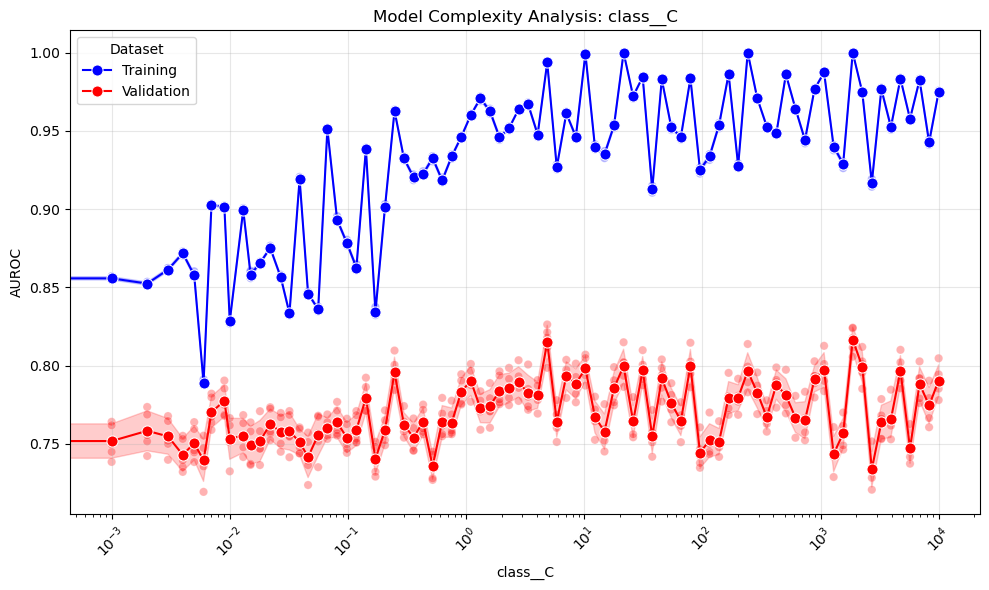

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_hyperparam_complexity_curves(results_df, param_name, 
                                    metric_name="mean_test_score",
                                    cv_folds=5):
    """ 绘制模型复杂度曲线（包含训练/验证集表现和不确定性）"""
    
    # 准备数据
    param_values = results_df[f"param_{param_name}"]
    param_col = f"param_{param_name}"
    
    # 提取所有交叉验证结果
    cv_metrics = []
    for split in range(cv_folds):
        cv_metrics.extend([
            (f"split{split}_train_score", "Training"),
            (f"split{split}_test_score", "Validation")
        ])
    # 创建长格式 DataFrame
    plot_data = []
    for metric_col, metric_type in cv_metrics:
        for para in results_df[param_col].unique():
            if param_name == "tfidf__ngram_range":
                para = str(para)
            plot_data.append({
                param_name: para,
                "Score": np.mean(results_df.loc[results_df[param_col] == para, metric_col]),
                "Type": metric_type
            })
    plot_df = pd.DataFrame(plot_data)
    # 处理参数类型
    if param_name == 'class__C':
        plot_df[param_name] = pd.to_numeric(plot_df[param_name])
    
    plt.figure(figsize=(10, 6))
    print(plot_df)
    # 绘制训练/验证曲线
    sns.lineplot(
        data=plot_df, 
        x=param_name, 
        y="Score", 
        hue="Type",
        errorbar='sd',  # 显示标准差
        err_style="band",  # 误差带
        estimator=np.mean,
        marker="o",
        markersize=8,
        palette={"Training": "blue", "Validation": "red"}
    )
    
    # 叠加所有交叉验证结果
    sns.scatterplot(
        data=plot_df,
        x=param_name, 
        y="Score",
        hue="Type",
        alpha=0.3,
        palette={"Training": "blue", "Validation": "red"},
        legend=False
    )
    
    # 设置对数坐标轴
    plt.xlabel(param_name)
    if param_name == 'class__C':
        plt.xscale('log')
        plt.xticks(rotation=45)
        
    plt.ylabel("AUROC")
    plt.title(f"Model Complexity Analysis: {param_name}")
    plt.legend(title="Dataset")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 示例使用（需要先运行 RandomSearch）
for param in [col.replace("param_", "") for col in param_columns]:
    print(param)
    plot_hyperparam_complexity_curves(
        results_df, 
        param,
        cv_folds=5
    )

In [99]:
results_df["param_tfidf__tokenizer"].unique()

array(['<function custom_tokenizer at 0x000001E61BA3FF60>', 'None'],
      dtype=object)